In [4]:
from utils.db_connection_utils import read_from_db
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from decimal import Decimal
from geopy.geocoders import Nominatim


The aim of this notebook is, making a linear interpolation with the points in data. Its not best way to solve issue but a good start point with mostly good results. Noise is low and mostly curves are wrong. Further development can be made. 


11.07.2024
noordhorn 2024-07-11 05:31:40
bad bentheimer 2024-07-11 05:48:59

Full route with 2 small interuptions as 30 second and 1 minute no data part. The missing parts are not curve so we can experiment with them. 
neuenhaus 2024-07-11 09:18:40
bad bentheimer2024-07-11 09:48:59

Full route with single 2 min intruption path is a bit like S shaped there but if connected directly wont be a lot wrong.  
bad bentheimer 2024-07-11 10:11:26
neuenhaus 2024-07-11 10:42:29

Full route with single 30 sec intruption staright rail.  
neuenhaus 2024-07-11 11:18:26
bad bentheimer 2024-07-11 11:50:00

Full route no interuption
bad bentheimer 2024-07-11 12:09:31 - 1720692571000
neuenhaus 2024-07-11 12:41:40 - 1720694500000




In [12]:
#Above there are 4 routes listed to test, below timestamps are from full route with no interruiption
start_timestamp = 1720692571000000000
end_timestamp =   1720693212000000000#1720694500000000000
q = f"""
    SELECT timestamp,lat,lon
    FROM loc_measurement 
    WHERE sensor_id = 85 and
    timestamp > {start_timestamp}
        AND timestamp < {end_timestamp}
"""
loc_df = read_from_db(q)
loc_df

,timestamp,lat,lon
0,1720692572000000000,52.310204,7.159168
1,1720692573000000000,52.310212,7.159223
2,1720692574000000000,52.310220,7.159284
3,1720692575000000000,52.310230,7.159350
4,1720692576000000000,52.310243,7.159424
...,...,...,...
635,1720693207000000000,52.385606,7.119923
636,1720693208000000000,52.385619,7.119578
637,1720693209000000000,52.385679,7.119257
638,1720693210000000000,52.385733,7.118928


In [6]:
from geopy.distance import geodesic

# simulation function which inputs data as int which is interval between 2 location points in seconds. 
def simulation(freq_of_data):
    loc_np= np.zeros(shape=(int(loc_df.shape[0]),3))
    # creates new numpy array and divides for second interval. Split distance equally
    for i in range(freq_of_data, loc_df.shape[0], freq_of_data):
        timestamp_difference = (loc_df.loc[i][0] - loc_df.loc[i-freq_of_data][0])/freq_of_data
        lat_difference = (loc_df.loc[i][1] - loc_df.loc[i-freq_of_data][1])/freq_of_data
        lon_difference = (loc_df.loc[i][2] - loc_df.loc[i-freq_of_data][2])/freq_of_data
        # construct points. 
        for j in range(freq_of_data-1):
            loc_np[i+j-freq_of_data, 0] = loc_df.loc[i-freq_of_data][0] + timestamp_difference*j
            loc_np[i+j-freq_of_data, 1] = loc_df.loc[i-freq_of_data][1] + lat_difference*j
            loc_np[i+j-freq_of_data, 2] = loc_df.loc[i-freq_of_data][2] + lon_difference*j
    total_lat_error = 0
    total_lon_error = 0
    passed_ones = 0  
    total_distance_error= 0
    #calculate erros
    # distance error is in meters
    for i in range(loc_df.shape[0]):
        lat_error = Decimal(abs(loc_df.loc[i][1] - loc_np[i,1]))
        lon_error = Decimal(abs(loc_df.loc[i][2] - loc_np[i,2]))
        # for some points data does not exist which means eror is full lat-lon. this check if error is approximately pur coordinates
        if not (lat_error > 50 or lon_error > 6.5): 
            total_distance_error = total_distance_error + geodesic((loc_df.loc[i][1],loc_df.loc[i][2]), (loc_np[i,1],loc_np[i,2])).m
            total_lat_error = total_lat_error + lat_error
            total_lon_error = total_lon_error + lon_error
            # bugfix prints if needed
            #print(f"index : {i}, lat error  {lat_error} ,lon error {lon_error},")
            #print(f"index : {i}, lat true {loc_df.loc[i][1]}  calc {loc_np[i,1]} ,lon  true {loc_df.loc[i][2]} calc {loc_np[i,2]}")
            #print(f"distance : {geodesic((loc_df.loc[i][1],loc_df.loc[i][2]), (loc_np[i,1],loc_np[i,2])).m },")
            #print('-------')
        else:
            # if points does not exist they are counted and they will be minused from total count
            passed_ones = passed_ones + 1
        
    # calculate average
    total_distance_error = total_distance_error / (loc_df.shape[0]-passed_ones)
    lat_average_error = total_lat_error/(loc_df.shape[0]-passed_ones)
    lon_average_error = total_lon_error/(loc_df.shape[0]-passed_ones)
    # bug prints
    #print(f"Lat average error {total_lat_error/(loc_df.shape[0]-passed_ones)}")
    #print(f"Lon average error {total_lon_error/(loc_df.shape[0]-passed_ones)}")
    #print(f"Ignored index count :  {passed_ones}")# ignore criteria is lat > 50 or lon >6.5 error by degrees. Possibly empty data or some other thing.
    return total_distance_error, lat_average_error, lon_average_error, loc_np



In [13]:
from utils.overpass_utils import find_closest_railway
from geopy.distance import geodesic

# simulation function which inputs data as int which is interval between 2 location points in seconds. 
def non_linear_simulation(freq_of_data):
    loc_np= np.zeros(shape=(int(loc_df.shape[0]),3))
    # creates new numpy array and divides for second interval. Split distance equally
    for i in range(freq_of_data, loc_df.shape[0], freq_of_data):
        timestamp_difference = (loc_df.loc[i][0] - loc_df.loc[i-freq_of_data][0])/freq_of_data
        lat_difference = (loc_df.loc[i][1] - loc_df.loc[i-freq_of_data][1])/freq_of_data
        lon_difference = (loc_df.loc[i][2] - loc_df.loc[i-freq_of_data][2])/freq_of_data
        # construct points. 
        for j in range(freq_of_data-1):
            calculated_lat = loc_df.loc[i-freq_of_data][1] + lat_difference*j
            calculated_lon = loc_df.loc[i-freq_of_data][2] + lon_difference*j
            loc_np[i+j-freq_of_data, 0] = loc_df.loc[i-freq_of_data][0] + timestamp_difference*j
            loc_np[i+j-freq_of_data, 1,],loc_np[i+j-freq_of_data, 2] = find_closest_railway(calculated_lat,calculated_lon)
    total_lat_error = 0
    total_lon_error = 0
    passed_ones = 0  
    total_distance_error= 0
    #calculate erros
    # distance error is in meters
    for i in range(loc_df.shape[0]):
        lat_error = Decimal(abs(loc_df.loc[i][1] - loc_np[i,1]))
        lon_error = Decimal(abs(loc_df.loc[i][2] - loc_np[i,2]))
        # for some points data does not exist which means eror is full lat-lon. this check if error is approximately pur coordinates
        if not (lat_error > 50 or lon_error > 6.5): 
            total_distance_error = total_distance_error + geodesic((loc_df.loc[i][1],loc_df.loc[i][2]), (loc_np[i,1],loc_np[i,2])).m
            total_lat_error = total_lat_error + lat_error
            total_lon_error = total_lon_error + lon_error
            # bugfix prints if needed
            #print(f"index : {i}, lat error  {lat_error} ,lon error {lon_error},")
            #print(f"index : {i}, lat true {loc_df.loc[i][1]}  calc {loc_np[i,1]} ,lon  true {loc_df.loc[i][2]} calc {loc_np[i,2]}")
            #print(f"distance : {geodesic((loc_df.loc[i][1],loc_df.loc[i][2]), (loc_np[i,1],loc_np[i,2])).m },")
            #print('-------')
        else:
            # if points does not exist they are counted and they will be minused from total count
            passed_ones = passed_ones + 1
        
    # calculate average
    total_distance_error = total_distance_error / (loc_df.shape[0]-passed_ones)
    lat_average_error = total_lat_error/(loc_df.shape[0]-passed_ones)
    lon_average_error = total_lon_error/(loc_df.shape[0]-passed_ones)
    # bug prints
    #print(f"Lat average error {total_lat_error/(loc_df.shape[0]-passed_ones)}")
    #print(f"Lon average error {total_lon_error/(loc_df.shape[0]-passed_ones)}")
    #print(f"Ignored index count :  {passed_ones}")# ignore criteria is lat > 50 or lon >6.5 error by degrees. Possibly empty data or some other thing.
    return total_distance_error, lat_average_error, lon_average_error, loc_np

The closest railway track is 5.24 meters away.
(52.3101567, 7.1591729)
The closest railway track is 6.34 meters away.
(52.3101657, 7.1592943)
The closest railway track is 6.70 meters away.
(52.3101692, 7.1593329)
The closest railway track is 7.44 meters away.
(52.3101845, 7.1594762)
The closest railway track is 7.64 meters away.
(52.3101958, 7.1595621)
The closest railway track is 7.68 meters away.
(52.3102029, 7.1596275)
The closest railway track is 9.25 meters away.
(52.3102029, 7.1596275)
The closest railway track is 13.52 meters away.
(52.3102029, 7.1596275)
The closest railway track is 18.42 meters away.
(52.3102661, 7.1601054)
The closest railway track is 13.48 meters away.
(52.3102661, 7.1601054)
The closest railway track is 9.73 meters away.
(52.3102661, 7.1601054)
The closest railway track is 8.83 meters away.
(52.3102661, 7.1601054)
The closest railway track is 10.76 meters away.
(52.3102869, 7.1602881)
The closest railway track is 11.59 meters away.
(52.3102869, 7.1602881)
T

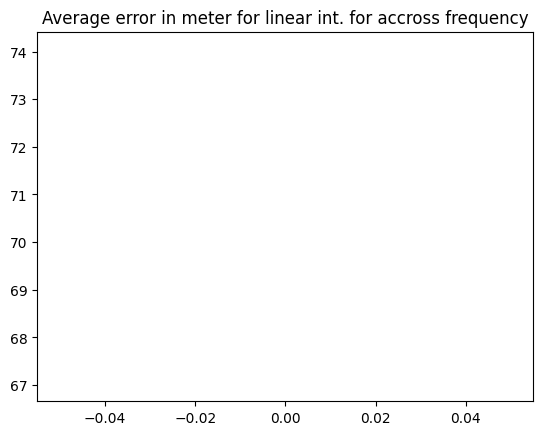

In [14]:
# simulate for 60 sec
#freq_of_data = 60
lats = []
lons = []
distances =[]
# below in seconds the highest interval in 2 points.
test_range = 15
global loc_np
# below from 2 second difference to variable test made
for freq_of_data in range(14,test_range):
    distance, lat, lon, loc_np = non_linear_simulation(freq_of_data)
    lats.append(lat)
    lons.append(lon)
    distances.append(distance)

# results plotted
plt.plot(distances)
plt.title("Average error in meter for linear int. for accross frequency")
plt.show()

#plt.plot(lats)
#plt.title("Lat average error for linear int. for accross frequency")
#plt.show()

#plt.title("Lon average error for linear int. for accross frequency")
#plt.plot(lons)
#plt.show()

There are lots of 30 meter away tracks in linear interpolation with matching rails. If the first location is more correct than the ground truuth (because of ex. point is in every 50 meters but our gps accuracy is 10 meters so actually matching made it worse.)
THis needs to be checked

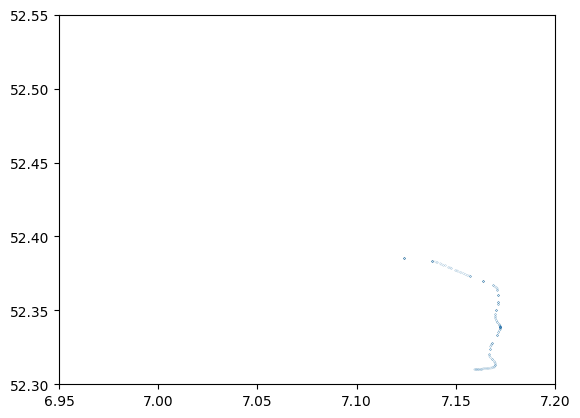

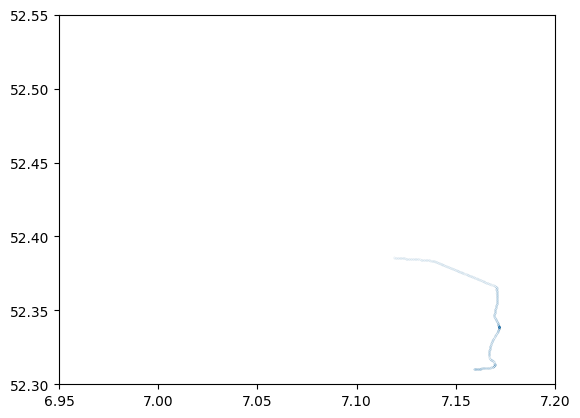

In [15]:
# here code prints the real data of bentheimer and filled data as scatter to compera difference visiually. 
# parameter is for freq of it. 
simulation(60)
plt.scatter(
    loc_np[:,2],
    loc_np[:,1],
    s=0.001
)
plt.xlim(6.95, 7.20)
plt.ylim(52.3, 52.55)
plt.show()

ground_loc_np = loc_df.to_numpy()
plt.scatter(
    ground_loc_np[:,2],
    ground_loc_np[:,1],
    s=0.001
)
plt.xlim(6.95, 7.20)
plt.ylim(52.3, 52.55)
plt.show()
#loc_np